
# Exp. 2 — Pun Cost Checking (Replication)

This notebook translates the provided **R** code for Experiment 2 into **Python** using `pandas`, `statsmodels`, and `matplotlib`.
It loads `/mnt/data/puncostcheckE2.csv`, fits the logistic model `checking ~ conditionA`, and reproduces the bar chart
with 95% CIs for **Observable** vs **Hidden**.

> File expected: `/mnt/data/puncostcheckE2.csv`


In [2]:

# Install (only if needed). In most environments these are already available.
# !pip -q install pandas statsmodels matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pathlib import Path

csv_path = Path("/home/limorgu/coding/replications/replication_paper/data/input/puncostcheckE2.csv")
assert csv_path.exists(), f"CSV not found at {csv_path}"


In [3]:

# ---------- Load data ----------
df = pd.read_csv(csv_path, sep=";")

# hygiene
df["PID"] = df["PID"].astype(str)
if "gender" in df.columns:
    df["gender"] = df["gender"].astype("category")

# ---------- Subset Player A (3=Observable, 4=Hidden) ----------
playerA = df[df["Condition"].isin([3, 4])].copy()

# helper: coalesce across two columns
def coalesce(a, b):
    out = a.copy()
    mask = out.isna()
    out.loc[mask] = b.loc[mask]
    return out

# ensure numeric
for col in ["checkObs", "checkHid", "calcPun", "uncalcPun"]:
    if col in playerA.columns:
        playerA[col] = pd.to_numeric(playerA[col], errors="coerce")

# derived variables (as in R)
playerA["checking"]  = coalesce(playerA["checkObs"],  playerA["checkHid"])   # 1=checked, 0=didn't
playerA["punishing"] = coalesce(playerA["calcPun"],   playerA["uncalcPun"])  # 1=punished, 0=didn't
playerA["conditionA"] = np.where(playerA["Condition"] == 3, 1, 0)            # 1=Observable, 0=Hidden

playerA = playerA.dropna(subset=["checking", "conditionA"]).copy()

playerA.head()


,PID,Duration,A1comp1,A1comp2,A1comp3,A1comp4,A2comp1,A2comp2,A2comp3,A2comp4OB,...,noCalc,punHid,noPunHid,gender,age,Condition,RecordedDate,checking,punishing,conditionA
0,1,214,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,2,22,3,15/11/2023 09:42,1.0,0.0,1
2,3,296,0.0,1.0,1.0,0.0,1.0,0.0,0.0,NaN,...,NaN,NaN,NaN,1,37,4,15/11/2023 09:44,1.0,0.0,0
4,5,331,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,NaN,NaN,NaN,1,34,3,15/11/2023 09:46,0.0,0.0,1
5,6,215,1.0,1.0,1.0,0.0,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,1,32,4,15/11/2023 09:46,1.0,0.0,0
9,10,260,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,1,47,3,15/11/2023 09:48,1.0,0.0,1


In [4]:

# ---------- Logistic regression: checking ~ conditionA ----------
X = sm.add_constant(playerA["conditionA"])
y = playerA["checking"]
glm_binom = sm.GLM(y, X, family=sm.families.Binomial())
res = glm_binom.fit()
print(res.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:               checking   No. Observations:                 1309
Model:                            GLM   Df Residuals:                     1307
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -866.79
Date:                Mon, 03 Nov 2025   Deviance:                       1733.6
Time:                        12:31:20   Pearson chi2:                 1.31e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01668
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7047      0.083      8.472      0.0

In [6]:

# ---------- Predicted probabilities + 95% CI (Observable, Hidden) ----------
pred_df = pd.DataFrame({"const":[1.0,1.0], "conditionA":[1,0]})
pred = res.get_prediction(pred_df)
pred_summary = pred.summary_frame(alpha=0.05)

labels = ["Observable", "Hidden"]
percentages = (pred_summary["mean"].values * 100).tolist()
ci_low = (pred_summary["mean_ci_lower"].values * 100).tolist()
ci_high = (pred_summary["mean_ci_upper"].values * 100).tolist()

# Raw proportions (sanity check)
obs_mask = playerA["conditionA"] == 1
hid_mask = playerA["conditionA"] == 0
raw_obs = playerA.loc[obs_mask, "checking"].mean() * 100
raw_hid = playerA.loc[hid_mask, "checking"].mean() * 100

print(f"""Raw % who check
- Observable: {raw_obs:.1f}%
- Hidden    : {raw_hid:.1f}%
\nModel-estimated (with 95% CI)
- Observable: {percentages[0]:.1f}%  (CI {ci_low[0]:.1f}–{ci_high[0]:.1f})
- Hidden    : {percentages[1]:.1f}%  (CI {ci_low[1]:.1f}–{ci_high[1]:.1f})
""")


Raw % who check
- Observable: 54.3%
- Hidden    : 66.9%

Model-estimated (with 95% CI)
- Observable: 54.3%  (CI 50.4–58.0)
- Hidden    : 66.9%  (CI 63.2–70.4)



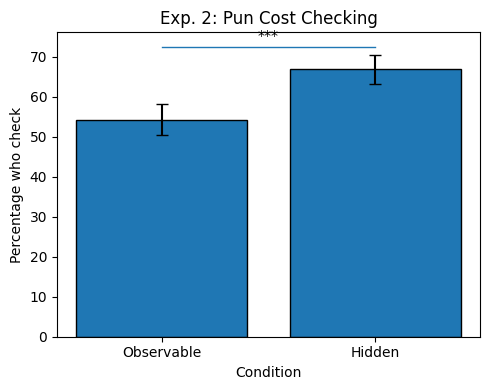

Saved figure to: /home/limorgu/coding/replications/replication_paper/data/output/e2_pun_cost_checking_plot.png


<Figure size 640x480 with 0 Axes>

In [8]:

# ---------- Plot the figure ----------
fig, ax = plt.subplots(figsize=(5, 4))

x = np.arange(len(labels))
yerr = [np.array(percentages) - np.array(ci_low), np.array(ci_high) - np.array(percentages)]
bars = ax.bar(x, percentages, yerr=yerr, capsize=4, edgecolor="black")

ax.set_title("Exp. 2: Pun Cost Checking")
ax.set_ylabel("Percentage who check")
ax.set_xlabel("Condition")
ax.set_xticks(x)
ax.set_xticklabels(labels)

# simple significance line + '***' (to mirror the R figure annotation)
y_top = max(ci_high) + 2
ax.plot([x[0], x[1]], [y_top, y_top], linewidth=1)
ax.text((x[0]+x[1])/2, y_top + 1, "***", ha="center", va="bottom")

plt.tight_layout()
plt.show()

# Optionally, save the figure
out_png = Path("/home/limorgu/coding/replications/replication_paper/data/output/e2_pun_cost_checking_plot.png")
plt.savefig(out_png, dpi=200)
print(f"Saved figure to: {out_png}")
